In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.io as io
from model.ExtendedTSSRP import ExtendedTSSRP
from model.Bspline import bsplineBasis
from spc import spc
from collections import Counter

# Plot

## Figure. 1: Visualize Tonnage

In [2]:
data = io.loadmat('data/tonnage.mat')
X = data['X']
y = data['y'][:,0]
vx = np.moveaxis(X,0,1).reshape(-1,582).T # Reshape the data
y[y==5]=2 # Relabel the label '5' to '2' 

data_normal = vx[y==0] # Select label 0 as normal sample
nNormalSample = vx[y==0].shape[0]
p = vx.shape[1] # Dimensionality of the data
nFailureMode = np.max(y)-1 # Falure Mode Number
nAbnormalSample = vx[y==1].shape[0] # sample number
data_abnormal = np.zeros((nFailureMode,nAbnormalSample,p)) # 5 failure modes, 69 samples, with 4804 dimension
for i in range(1,nFailureMode+1):
    data_abnormal[i-1] = vx[y==i]

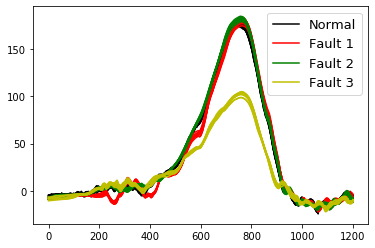

In [3]:
plt.plot(data_normal[0:10].reshape(10,4,1201)[:,0].T,'k')
plt.plot(data_normal[0].reshape(1,4,1201)[:,0].T,'k',label='Normal')
notation = ['r','g','y']
Faultlist = ['Fault 1', 'Fault 2', 'Fault 3']
for i in range(3):
    plt.plot(data_abnormal[i][0:10].reshape(10,4,1201)[:,0].T,notation[i])
    plt.plot(data_abnormal[i][0].reshape(1,4,1201)[:,0].T,notation[i],label=Faultlist[i])
plt.legend(prop={'size': 13})

## Figure 2: Visualize Additive Manufacturing

In [4]:
data = io.loadmat('data/temperature.mat')
X_org = data['mMov0']
X_org = np.rollaxis(X_org,2,0)

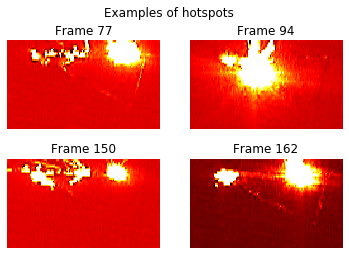

In [5]:
fig=plt.figure()
hotspots = [77, 94, 150, 162]
for i in range(1,5):
    ax=fig.add_subplot(2,2,i)        
    ax.imshow(X_org[hotspots[i-1]-1],cmap=plt.get_cmap('hot'))
    ax.set_title('Frame {}'.format(hotspots[i-1]))
    ax.axis('off')
fig.suptitle('Examples of hotspots') # or plt.suptitle('Main title')
# plt.savefig('figs/case_3d_example.eps')
plt.show()

## Figure 3: Visualize the Failure Modes

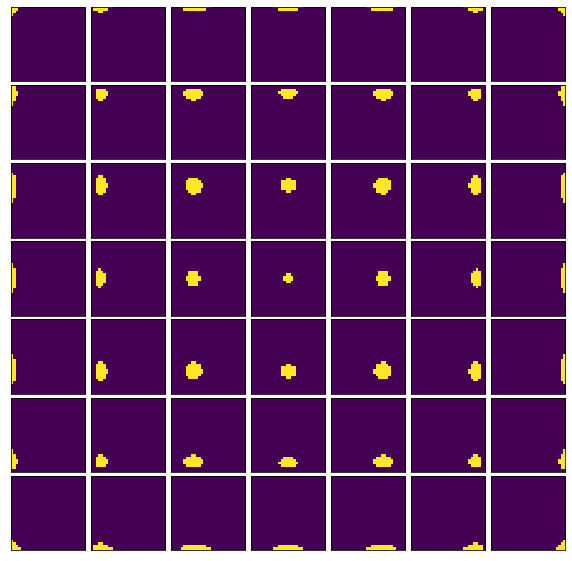

In [6]:
# case = 'nonoverlap'
case = 'spline'
if case == 'nonoverlap':
    p = 1000 # Number of dimensions
    c = 1 # Target meanshift is c * M
    k = 50 # Number of failuer Modes
    seed_list_OC = 20 # Seed of data generation
    sel_failure_mode = [9,19,29]    #  Failure Mode
    M = np.kron(np.eye(k),np.ones((int(p/k),1))) # Mean Failure Modes
else:
    p = 900
    c = 1 
    k0 = 7 # Can be changed (Knots)
    k = k0**2 # Failre mode number 
    degree = 4 # Overlap region? (Size of B-spline basis) 
    B1 = bsplineBasis(30,k0-degree+1,degree)
    M = np.kron(B1,B1)
    M[M<np.quantile(M,0.975)] = 0
    M[M>0] = 1
    sel_failure_mode = [3,11,22]    #  Failure Mode
Ks = 5  #Select Top Ks control chart
nsensors = 5 # Number of selected sensors
ARL0 = 200 # Target ARL-IC
Tmax = 500 # Maximum length

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(7, 7)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(M.shape[1]):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(M[:,i].reshape([30,30])) 
    ax1.set_xticks([]) 
    ax1.set_yticks([]) 

fig.savefig('figs/' + case + 'allmodes.eps')

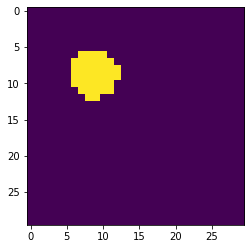

In [7]:
ifailuremode = 16
# plt.plot(B1)
plt.imshow(M[:,ifailuremode].reshape([30,30]))

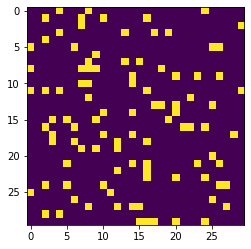

In [8]:
#ifailuremode 14
x = np.random.uniform(low=0.0, high=1.0, size=(30,30))
failure_matrix = M[:,ifailuremode].reshape([30,30])
combine = failure_matrix*0.1 + x

# Convert it into a 1D array
a_1d = combine.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-100:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, combine.shape)

result = np.zeros((30,30))
result[x_idx,y_idx]=1
plt.imshow(result)

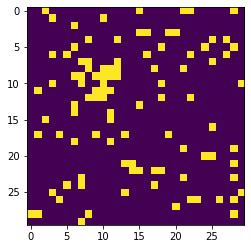

In [9]:
#ifailuremode 14
x = np.random.uniform(low=0.0, high=1.0, size=(30,30))
failure_matrix = M[:,ifailuremode].reshape([30,30])
combine = failure_matrix*0.5 + x

# Convert it into a 1D array
a_1d = combine.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-100:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, combine.shape)

result = np.zeros((30,30))
result[x_idx,y_idx]=1
plt.imshow(result)

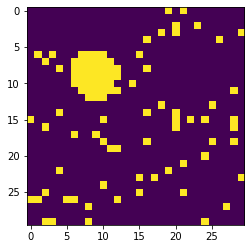

In [10]:
#ifailuremode 14
x = np.random.uniform(low=0.0, high=1.0, size=(30,30))
failure_matrix = M[:,ifailuremode].reshape([30,30])
combine = failure_matrix*0.9 + x

# Convert it into a 1D array
a_1d = combine.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-100:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, combine.shape)

result = np.zeros((30,30))
result[x_idx,y_idx]=1
plt.imshow(result)

## Case non-overlap

In [11]:
case = 'nonoverlap'
#case = 'spline'
if case == 'nonoverlap':
    p = 1000 # Number of dimensions
    c = 1 # Target meanshift is c * M
    k = 50 # Number of failuer Modes
    seed_list_OC = 10 # Seed of data generation
    sel_failure_mode = [3,11,22]    #  Failure Mode
    M = np.kron(np.eye(k),np.ones((int(p/k),1))) # Mean Failure Modes
else:
    p = 900
    c = 1 
    k0 = 6 # Can be changed (Knots)
    k = k0**2 # Failre mode number 
    degree = 4 # Overlap region? (Size of B-spline basis) 
    B1 = bsplineBasis(30,k0-degree+1,degree)
    M = np.kron(B1,B1)
    sel_failure_mode = [3,11,22]    #  Failure Mode
Ks = 5  #Select Top Ks control chart
nsensors = 20 # Number of selected sensors
ARL0 = 200 # Target ARL-IC
Tmax = 500 # Maximum length

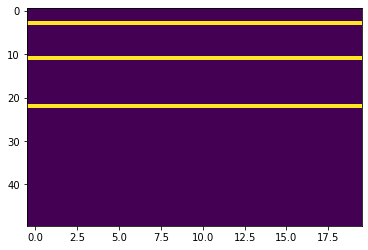

In [12]:
plt.imshow(M[:,sel_failure_mode].sum(1).reshape([50,20]),aspect='auto')

In [13]:
def data_gen_func0(n_batch, Tmax, seed):
    # Generate normal samples
    np.random.seed(seed)    
    data = np.random.randn(n_batch,Tmax,p)
    return data

def data_gen_func1(n_batch, Tmax, seed, T0, delta):
    # Generate abnormal samples
    np.random.seed(seed)
    D1 = np.random.randn(n_batch, Tmax, p)
    shift = np.sum(M[:,sel_failure_mode]*delta,1)
    for i in range(T0,Tmax):
        for j in range(n_batch):
            D1[j,i,:] = D1[j,i,:]+shift
    return D1

In [14]:
truesensidx = np.arange(nsensors)
nmodels = 1
model_all = [[] for i in range(nmodels)]

# p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode = 'T2'
    
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2')


model_name = ['E_srp_T2']

T0 = 100
Tmax = 200
delta = 1
seed_list_OC = [0,2,5]
x = data_gen_func1(3, Tmax, seed_list_OC, T0, delta)

imodel = 0
model = model_all[imodel]

sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model.compute_monitoring_statistics(x[0],T0,-1)

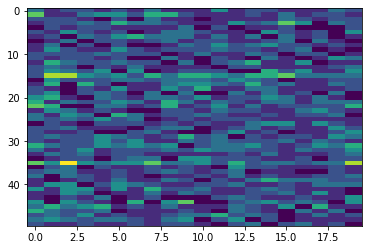

In [15]:
count_distr = Counter(sensor_selection_history[:T0].reshape(-1) ).items()

distr = np.zeros(1000)
for i,v in count_distr:
    distr[int(i)] = v
plt.imshow(distr.reshape(50,20),aspect='auto')

(-0.5, 19.5, 49.5, -0.5)

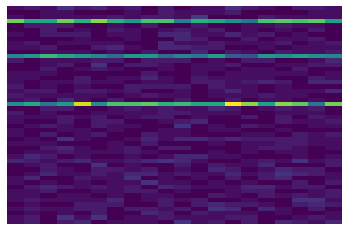

In [16]:
count_distr = Counter(sensor_selection_history[T0:].reshape(-1) ).items()

distr = np.zeros(1000)
for i,v in count_distr:
    distr[int(i)] = v
plt.imshow(distr.reshape(50,20),aspect='auto')
plt.axis('off')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


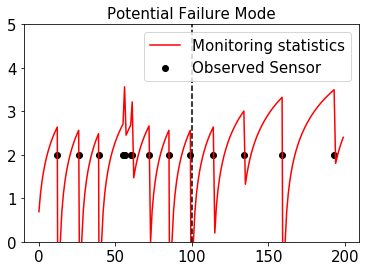

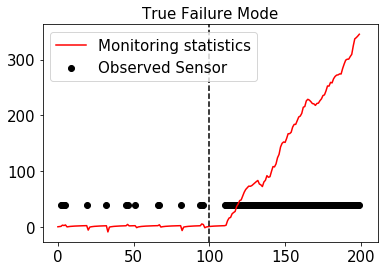

In [17]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

for plotfailuremode in [5,22]:
    arr = np.array([plotfailuremode in i for i in sensor_selection_history])
    plt.figure()    
    plt.plot(sequential_statistics[:,plotfailuremode],'r',label='Monitoring statistics')
    mode = (sensor_selection_history/(p/k)).astype(int)
    numSensorInFailureMode = np.zeros(Tmax)
    for ii,i in enumerate(mode):
        numSensorInFailureMode[ii] = np.sum([j ==plotfailuremode for j in i])
    idx = np.where(numSensorInFailureMode)[0]
    if plotfailuremode == 5:
        plt.title('Potential Failure Mode')
        plt.ylim((0,5))
        _ = plt.scatter(idx,numSensorInFailureMode[idx]*0+2,label = 'Observed Sensor',c='black')
    elif plotfailuremode == 22:
        plt.title('True Failure Mode')
        _ = plt.scatter(idx,numSensorInFailureMode[idx]*0+40,label = 'Observed Sensor',c='black')        
    plt.axvline(x=100,color='k',linestyle='--')

    plt.legend()

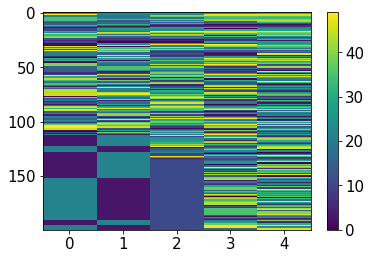

In [18]:
plt.imshow(failure_mode_history,aspect='auto')
plt.colorbar()
# plt.ylabel('Time')
plt.savefig('figs/pattern_nonoverlap.eps')

## Case overlap

In [19]:
case = 'spline'
if case == 'nonoverlap':
    p = 1000 # Number of dimensions
    c = 1 # Target meanshift is c * M
    k = 50 # Number of failuer Modes
    seed_list_OC = 10 # Seed of data generation
    sel_failure_mode = [3,11,22]    #  Failure Mode
    M = np.kron(np.eye(k),np.ones((int(p/k),1))) # Mean Failure Modes
else:
    p = 900
    c = 1 
    k0 = 7 # Can be changed (Knots)
    k = k0**2 # Failre mode number 
    degree = 4 # Overlap region? (Size of B-spline basis) 
    B1 = bsplineBasis(30,k0-degree+1,degree)
    M = np.kron(B1,B1)
    sel_failure_mode = [34,35,3]     #  Failure Mode
#     M[M<np.quantile(M,0.975)] = 0
#     M[M>0] = 1
Ks = 5 #Select Top Ks control chart
nsensors = 80 # Number of selected sensors
ARL0 = 200 # Target ARL-IC
Tmax = 500 # Maximum length

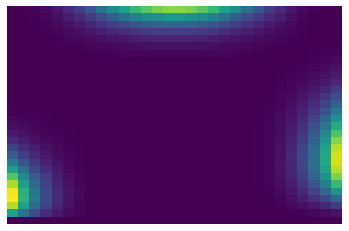

In [20]:
plt.imshow(M[:,sel_failure_mode].sum(1).reshape([30,30]),aspect='auto')
plt.axis('off')
plt.savefig('figs/true_anomaly_bspline'+'.eps')

In [21]:
def data_gen_func0(n_batch, Tmax, seed):
    # Generate normal samples
    np.random.seed(seed)    
    data = np.random.randn(n_batch,Tmax,p)
    return data

def data_gen_func1(n_batch, Tmax, seed, T0, delta):
    # Generate abnormal samples
    np.random.seed(seed)
    D1 = np.random.randn(n_batch, Tmax, p)
    shift = np.sum(M[:,sel_failure_mode]*delta,1)
    for i in range(T0,Tmax):
        for j in range(n_batch):
            D1[j,i,:] = D1[j,i,:]+shift
    return D1

In [22]:
truesensidx = np.arange(nsensors)
nmodels = 1
model_all = [[] for i in range(nmodels)]

# p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode = 'T2'
    
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2')


model_name = ['E_srp_T2']

T0 = 100
Tmax = 200
delta = 2
seed_list_OC = [0,2,5]
x = data_gen_func1(3, Tmax, seed_list_OC, T0, delta)

imodel = 0
model = model_all[imodel]

sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model.compute_monitoring_statistics(x[0],T0,-1)

(-0.5, 29.5, 29.5, -0.5)

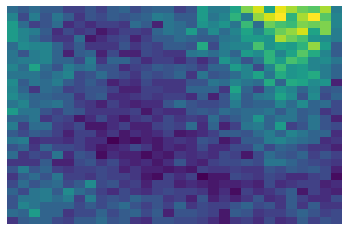

In [23]:
count_distr = Counter(sensor_selection_history[:T0].reshape(-1) ).items()

distr = np.zeros(900)
for i,v in count_distr:
    distr[int(i)] = v
plt.imshow(distr.reshape(30,30),aspect='auto')

plt.axis('off')

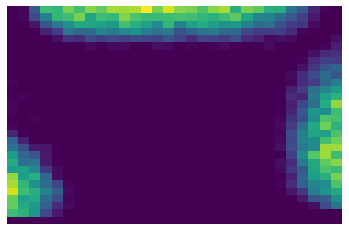

In [24]:
count_distr = Counter(sensor_selection_history[T0:].reshape(-1) ).items()

distr = np.zeros(900)
for i,v in count_distr:
    distr[int(i)] = v
plt.imshow(distr.reshape(30,30),aspect='auto')
plt.axis('off')
plt.savefig('figs/oc_bspline'+'.eps')

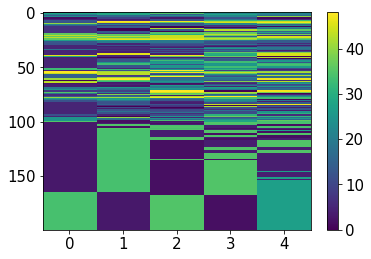

In [25]:
plt.imshow(failure_mode_history,aspect='auto')
plt.colorbar()
# plt.xlabel('Falure Mode Ranking')
# plt.ylabel('Time')
plt.savefig('figs/pattern_bspline.eps')

## Figure 13

In [26]:
data = io.loadmat('data/temperature.mat')
X_org = data['mMov0']
X = data['mMov1']
X = np.rollaxis(X,2,0)
X_org = np.rollaxis(X_org,2,0)
with open(r"result/case_am_sensor_selection.obj", "rb") as input_file:
    sensor_selection_history = pickle.load(input_file)
with open(r"result/case_am_failure_mode.obj", "rb") as input_file:
    failure_mode_history = pickle.load(input_file)
nt,nx,ny = X.shape

In [27]:
printingregion = np.sum(X_org,0)>30
defectregion = X[-100]
kx = 20
ky = 30
degree = 2 # Overlap region? (Size of B-spline basis) 
Bx = bsplineBasis(nx,kx-degree+1,degree)
By = bsplineBasis(ny,ky-degree+1,degree)
Mall = np.kron(Bx,By)

ii = []
MMregion = 0
for i in np.arange(Mall.shape[1]):
    mM = Mall[:,i].reshape(nx,ny)
    mMregion = mM > 0.1
    res = np.logical_and(mMregion,printingregion)
    if np.sum(res[:]) > 20:
        ii.append(i) 
        MMregion = MMregion + mM
M = Mall[:,ii]

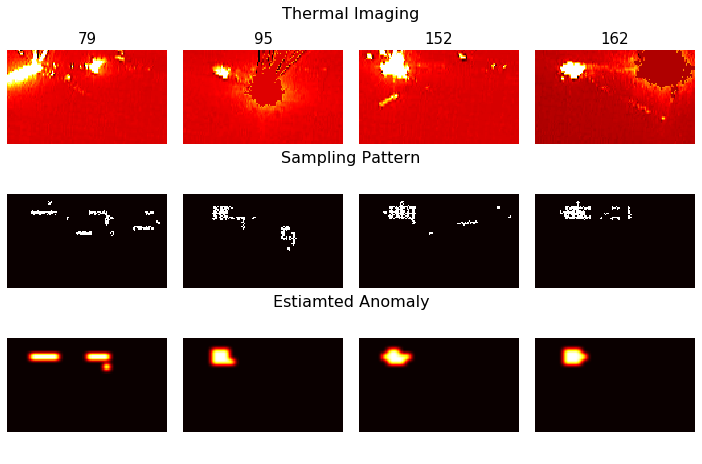

In [28]:
import matplotlib.pyplot as plt

fig, big_axes = plt.subplots( figsize=(10,10) , nrows=3, ncols=1, sharey=True) 

row_name = ['Thermal Imaging', 'Sampling Pattern', 'Estiamted Anomaly']
i = 0
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(row_name[i], fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    plt.setp(big_ax.get_xticklabels(), visible=False)
    plt.setp(big_ax.get_yticklabels(), visible=False)
    big_ax.tick_params(axis='both', which='both', length=0)

    # removes the white frame
    big_ax._frameon = False
    i += 1

col_name = [79, 95, 152, 162]
for i in range(4):
    t = col_name[i]
    ax = fig.add_subplot(3,4,1+i)
    ax.set_title(str(t))
    ax.imshow(X[t],cmap=plt.get_cmap('hot'))
    ax.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax = fig.add_subplot(3,4,5+i)
    
    S = np.zeros((nx*ny))
    S[sensor_selection_history[t].astype(int)] = 1
    mS = S.reshape(nx,ny)
    ax.imshow(mS,cmap=plt.get_cmap('hot'))
    ax.axis('off')

    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    
    ax = fig.add_subplot(3,4,9+i)
   
    ax.imshow(np.sum(M[:,failure_mode_history[t,0:10].astype(int)],axis=1).reshape(nx,ny),cmap=plt.get_cmap('hot'))
    ax.axis('off')

    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    
fig.set_facecolor('w')
plt.tight_layout()

plt.subplots_adjust(bottom=0.3, top=0.9, hspace=0)

plt.savefig('figs/case_3d.png')

## Figure. 14

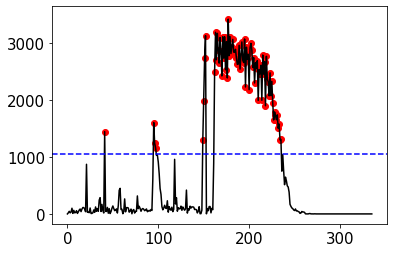

In [29]:
with open(r"result/case_am_statistics.obj", "rb") as input_file:
    sequential_statistics_topRsum = pickle.load(input_file)
plt.plot(sequential_statistics_topRsum,'k-')
toscatter = np.where((sequential_statistics_topRsum>1050))[0]
for idx,yidx in enumerate(toscatter):
    plt.scatter(yidx, sequential_statistics_topRsum[yidx],c='r')
#plt.axvline(x=78, color='b', linestyle='--')
#plt.axvline(x=96, color='b', linestyle='--')
#plt.axvline(x=152, color='b', linestyle='--')
#plt.axvline(x=164, color='b', linestyle='--')
plt.axhline(y=1050, color='b', linestyle='--')
plt.savefig('figs/case_3d_s.eps')